# Задача 4. Ансамбли

- Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- *(выполненная доп. задача)* Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- *(выполненная доп. задача)* Для подбора гиперпараметров использовать фреймворк **Optuna**.

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Датасет

Будем использовать California Housing dataset, встроенный в scikit-learn и содержащий информацию о группах домов в Калифорнии. Группы домов — множества соседних домов, о которых Бюро переписи населения США публикует соответствующие данные. Домохозяйство — люди, живущие в одном доме.

На данных предполагается решать задачу регрессии: определить среднюю цену домов в группе по демографическим данным и географическому положению группы.

Нецелевые аттрибуты:
- MedInc — средний доход населения группы
- HouseAge — средний возраст домов в группе
- AveRooms — среднее число комнат на домохозяйство
- AveBedrms — среднее число спален на домохозяйство
- Population — население группы
- AveOccup — среднее число человек в домохозяйствах
- Latitude — географическая широта центра группы
- Longitude — географическая долгота центра группы

Целевой аттрибут:
- MedHouseVal — средняя цена дома в группе в сотнях тысяч долларов ($100000)

In [48]:
from sklearn.datasets import fetch_california_housing

dataset = fetch_california_housing(as_frame=True)
dataset.frame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [106]:
dataset.frame.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [107]:
dataset.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


В данных нет пропущенных значений, следовательно, их корректировка не требуются.

Однако, можно проследить порядок в географическом расположении (возможно, группы вносились в список "от соседа к соседу"), поэтому **при кросс-валидации данные стоит перемешивать**, чтобы не получать промежутки только из географически соседних групп.

Также для последующей оценки ошибок заметим, что средняя цена дома составляет около $200.000.

## Разведочный анализ (EDA)

### Распределение данных

Рассмотрим распределения всех аттрибутов.

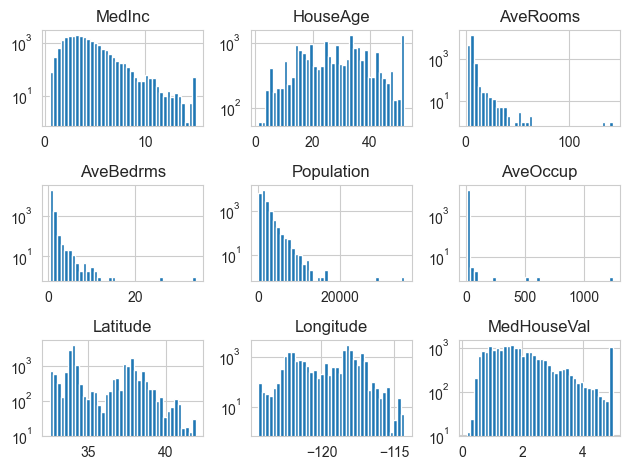

In [50]:
dataset.frame.hist(bins=40, log=True)
plt.tight_layout()

У аттрибутов MedInc, HouseAge, MedHouseVal распределения более-менее плавные. Однако, у них всех наблюдается резкий всплеск у максимума — видимо, значения были ограничены сверху и округлялись до приведенных ниже максимумов.

In [51]:
dataset.frame[["MedInc", "HouseAge", "MedHouseVal"]].max()

MedInc         15.00010
HouseAge       52.00000
MedHouseVal     5.00001
dtype: float64

Значения аттрибутов AveRooms, AveBedrms, Population и AveOccup, ожидаемо, сосредоточены у минимума и резко падают при увеличении значений. Значения, которыми ограничивается 99% значений этих аттрибутов (и их сравнения с максимумами для демонстрации скачка), приведены ниже.

In [52]:
dataset.frame.describe(percentiles=[.99])[["AveRooms", "AveBedrms", "Population", "AveOccup"]].loc[["99%", "max"]]

,AveRooms,AveBedrms,Population,AveOccup
99%,10.357033,2.127541,5805.83,5.394812
max,141.909091,34.066667,35682.00,1243.333333


### Корреляция аттрибутов

Сначала попробуем проследить зависимости негеографических аттрибутов.

Отметим, что **с ростом среднего дохода населения (MedInc) растёт и цена их домов (целевой признак)**.

Также можно проследить ожидаемую положительную корреляцию между средним числом комнат (AveRooms) и средним числом спален (AveBedrms). Однако, исходя из здравого смысла, всё же оставим оба аттрибута.

<Axes: >

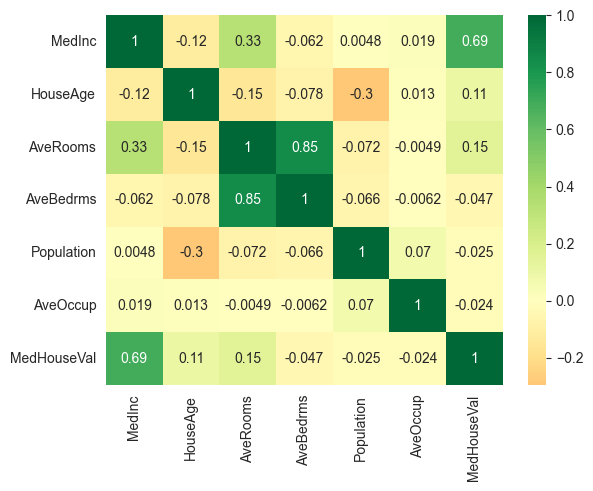

In [53]:
sns.heatmap(dataset.frame.drop(columns=["Latitude", "Longitude"]).corr(), center=0, annot=True, cmap="RdYlGn")

Используя данные географических координат, можно проследить зависимость средней цены домов (то есть целевого аттрибута) от их местоположения на карте. Как видно, **дома у берега и неподалеку от мегаполисов стоят дороже остальных**.

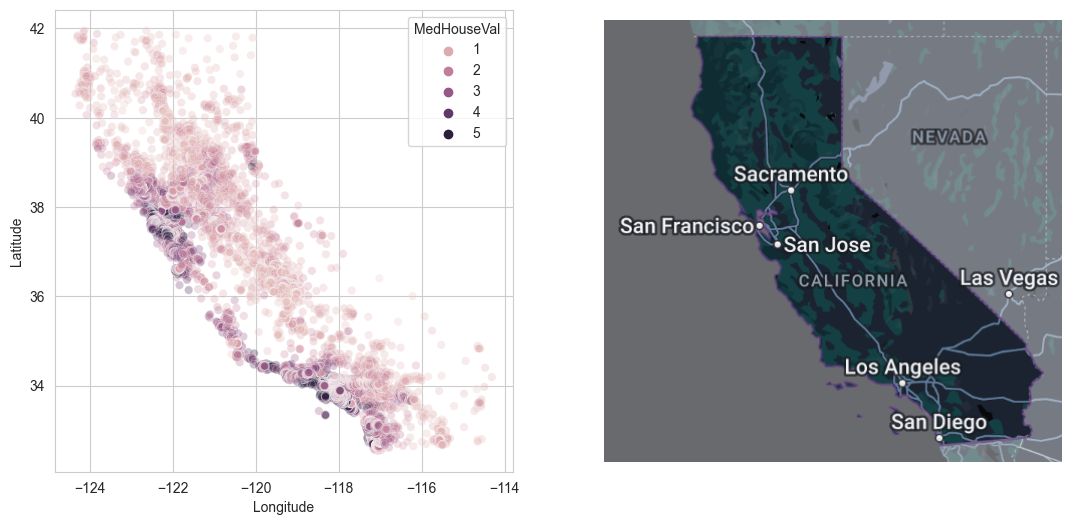

In [119]:
import imageio

fig, (scatter_ax, map_ax) = plt.subplots(ncols=2, figsize=(13, 6))

sns.scatterplot(dataset.frame, x="Longitude", y="Latitude", hue="MedHouseVal", alpha=0.3, ax=scatter_ax)

map_ax.imshow(imageio.imread_v2("https://i.imgur.com/p2hNI7R.png"))
map_ax.set_axis_off()

plt.show()

Таким образом, можно ожидать, что **средних доход населения (MedInc) и географическое местоположение (Latitude и Longitude) будут ощутимо влиять на целевой аттрибут (MedHouseVal)**.

## Собственные реализации ансамблей

In [55]:
import numpy as np
import numpy.typing as npt
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_X_y, check_scalar, check_random_state, check_is_fitted, check_array
from sklearn.utils.estimator_checks import check_estimator

### Bagging

In [56]:
class SimpleBaggingRegressor(BaseEstimator, RegressorMixin):
    """ Простейший bagging-регрессор, совместимый с scikit-learn API. """

    def __init__(self, estimator=None, n_estimators=10, *, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def _set_estimator(self):
        """ Выставляет estimator-образец. """
        self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeRegressor()

    def _set_random_states(self, estimator):
        """ Расставляет random_state для estimator и всех его потомков. Основано на _set_random_states из scikit-learn. """
        random_states = {}
        for param_name in estimator.get_params(deep=True):
            if param_name == "random_state" or param_name.endswith("__random_state"):
                random_states[param_name] = self.random_state_.tomaxint()
        estimator.set_params(**random_states)

    def _bootstrap_resample(self, X: npt.NDArray, y: npt.NDArray) -> tuple[npt.NDArray, npt.NDArray]:
        """ На основе переданных данных создает перемешанные данные с повторениями того же размера. """
        bootstrap_indices = self.random_state_.choice(len(y), size=len(y))
        return X[bootstrap_indices], y[bootstrap_indices]

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "SimpleBaggingRegressor":
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)

        self._set_estimator()

        self.estimators_ = []
        for i in range(self.n_estimators):
            estimator = clone(self.estimator_)
            self._set_random_states(estimator)
            X_sample, y_sample = self._bootstrap_resample(X, y)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)

        self.n_features_in_ = X.shape[1]

        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)

        predictions = [estimator.predict(X) for estimator in self.estimators_]
        aggregated = np.mean(predictions, axis=0)
        return aggregated


# Проверка на совместимость с scikit-learn
check_estimator(SimpleBaggingRegressor())

### AdaBoost

In [57]:
class SimpleAdaBoostRegressor(BaseEstimator, RegressorMixin):
    """ Регрессор, основанный на AdaBoost.R2 и совместимый с scikit-learn API. """

    def __init__(self, estimator=None, n_estimators=50, *, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def _set_estimator(self):
        """ Выставляет estimator-образец. """
        self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeRegressor(max_depth=3)

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "SimpleAdaBoostRegressor":
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y, y_numeric=True)

        self._set_estimator()

        self.estimators_ = []
        self.estimator_weights_ = []
        sample_weight = np.full(len(y), fill_value=(1 / len(y)))
        for _ in range(self.n_estimators):
            estimator = clone(self.estimator_)
            predicted = estimator.fit(X, y, sample_weight=sample_weight).predict(X)

            # Считаем линейную ошибку
            errors = np.abs(predicted - y)
            max_error = np.max(errors)
            if max_error > 0:  # Убедимся, что 0 <= errors[i] <= 1 Для всех i
                errors /= max_error
            avg_error = np.sum(errors * sample_weight)  # 0 <= avg_error <= 1

            # Если ошибка отсутствует или слишком велика, то требуется завершить бустинг
            if avg_error == 0:
                self.estimators_.append(estimator)
                self.estimator_weights_.append(1.0)
                break
            elif avg_error >= 0.5:
                # Нам необходим хотя бы один алгоритм
                if len(self.estimators_) == 0:
                    self.estimators_.append(estimator)
                    self.estimator_weights_.append(1.0)
                break

            # Обновляем веса
            beta = avg_error / (1 - avg_error)  # 0 < beta < 1, так как 0 < avg_error < 0.5
            sample_weight *= np.power(beta, 1 - errors)  # Чем выше ошибка, тем выше соответствующий вес

            # Нормализуем веса сэмплов
            sample_weight /= np.sum(sample_weight)

            # Пополняем ансамбль
            self.estimators_.append(estimator)
            self.estimator_weights_.append(np.log(1 / beta))
        self.estimator_weights_ = np.array(self.estimator_weights_)

        self.n_features_in_ = X.shape[1]

        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)

        predictions = np.array([estimator.predict(X) for estimator in self.estimators_]).T

        # Сортировка для каждого набора
        sorted_prediction_ids = np.argsort(predictions, axis=1)
        # Считаем кумулятивные суммы весов по каждому набору с учетом сортировки
        sorted_weights_cumsum = np.cumsum(self.estimator_weights_[sorted_prediction_ids], axis=1)
        # Для каждого набора находим индекс первого алгоритма, с кумулятивным весом не меньше среднего
        is_median_or_above = sorted_weights_cumsum >= (sorted_weights_cumsum[0][-1] / 2)
        median_ids = np.argmax(is_median_or_above, axis=1)  # Индексы первых True в колонках, то есть медиан
        median_ids = sorted_prediction_ids[np.arange(len(X)), median_ids]  # Перевод обратно в несортированные

        # Агрегированные значения — взвешенные медианы (берётся первое по величине значение, для которого кумулятивный вес достиг половины общего веса)
        aggregated = predictions[np.arange(len(X)), median_ids]

        return aggregated


# Проверка на совместимость с scikit-learn
check_estimator(SimpleAdaBoostRegressor())

## Обучение средствами Optuna

In [58]:
import pathlib
import warnings

import optuna
from sklearn.model_selection import KFold, cross_validate

# Отключаем warning об "экспериментальности"
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

RESULTS_PATH = pathlib.Path("cv_results.csv")

def train_and_store(estimator, param_distributions: dict):
    # Используем BruteForceSampler, так как во всех случаях число значений параметров конечно
    optuna.logging.set_verbosity(optuna.logging.WARNING)  # Убираем логи о создании study
    study = optuna.create_study(sampler=optuna.samplers.BruteForceSampler(999), direction="maximize")
    optuna.logging.set_verbosity(optuna.logging.INFO)

    # Оборачиваем модель для кросс-валидации гипер-параметров
    search_model = optuna.integration.OptunaSearchCV(
        estimator,
        param_distributions,
        scoring="r2",
        n_jobs=2,
        n_trials=None,  # Пробуем все варианты через BruteForceSampler
        random_state=99,
        study=study,
    )

    # Используем обернутую модель при кросс-валидации обучаемых параметров
    cv_results = cross_validate(
        search_model,
        dataset.data,
        dataset.target,
        cv=KFold(shuffle=True, random_state=15),  # Перемешиваем, чтобы не получать группы из географических соседей
        scoring=["r2", "neg_mean_absolute_error"],
        n_jobs=3,
        return_estimator=True,
    )

    for fold_i, estimator_in_fold in enumerate(cv_results["estimator"], start=1):
        print(f"Best params #{fold_i}:", estimator_in_fold.best_params_)

    cv_results = pd.DataFrame(cv_results).rename(
        columns={"estimator": "Regressor", "fit_time": "Fit time, s", "score_time": "Score time, s", "test_r2": "R2 on test"}
    )
    cv_results["Regressor"] = estimator.__class__.__name__.removesuffix("Regressor")
    cv_results["MAE on test"] = -cv_results["test_neg_mean_absolute_error"]
    cv_results = cv_results.drop(columns=["test_neg_mean_absolute_error"])
    cv_results.to_csv(RESULTS_PATH, mode="a", header=not RESULTS_PATH.exists())

### Bagging

In [59]:
%%time

train_and_store(
    SimpleBaggingRegressor(random_state=0),
    param_distributions={
        # Чем больше, тем лучше результат, но медленнее работа — кросс-валидация этого не учитывает, поэтому ограничимся здравым смыслом
        "n_estimators": optuna.distributions.CategoricalDistribution([20, 40, 80]),
    },
)

Best params #1: {'n_estimators': 80}
Best params #2: {'n_estimators': 80}
Best params #3: {'n_estimators': 80}
Best params #4: {'n_estimators': 80}
Best params #5: {'n_estimators': 80}
CPU times: total: 641 ms
Wall time: 1min 26s


In [60]:
%%time
from sklearn.ensemble import BaggingRegressor

train_and_store(
    BaggingRegressor(random_state=1, n_jobs=2),
    param_distributions={
        # Чем больше, тем лучше результат, но медленнее работа — кросс-валидация этого не учитывает, поэтому ограничимся здравым смыслом
        "n_estimators": optuna.distributions.CategoricalDistribution([20, 40, 80]),
    }
)

Best params #1: {'n_estimators': 80}
Best params #2: {'n_estimators': 80}
Best params #3: {'n_estimators': 80}
Best params #4: {'n_estimators': 80}
Best params #5: {'n_estimators': 40}
CPU times: total: 609 ms
Wall time: 1min 14s


In [61]:
%%time
from sklearn.ensemble import RandomForestRegressor

train_and_store(
    RandomForestRegressor(random_state=2, n_jobs=2),
    param_distributions={
        # Чем больше, тем лучше результат, но медленнее работа — кросс-валидация этого не учитывает, поэтому ограничимся здравым смыслом
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 200, 400]),
        # Чем больше число (2, sqrt(N), N), тем больше случайности
        "max_features": optuna.distributions.CategoricalDistribution([2, "sqrt", None]),
        # Чем больше, тем выше "переобучаемость" деревьев (влияет на их глубину)
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
    },
)

Best params #1: {'n_estimators': 100, 'max_features': None, 'max_leaf_nodes': None}
Best params #2: {'n_estimators': 400, 'max_features': None, 'max_leaf_nodes': None}
Best params #3: {'n_estimators': 400, 'max_features': None, 'max_leaf_nodes': None}
Best params #4: {'n_estimators': 400, 'max_features': None, 'max_leaf_nodes': None}
Best params #5: {'n_estimators': 400, 'max_features': None, 'max_leaf_nodes': None}
CPU times: total: 2.7 s
Wall time: 16min 52s


### Boosting

In [62]:
%%time

train_and_store(
    SimpleAdaBoostRegressor(random_state=3),
    param_distributions={
        # Чем выше, тем больше шагов корректировки, но это может привести к переобучению ансамбля в целом
        "n_estimators": optuna.distributions.CategoricalDistribution([25, 50, 100]),
    },
)

Best params #1: {'n_estimators': 25}
Best params #2: {'n_estimators': 25}
Best params #3: {'n_estimators': 25}
Best params #4: {'n_estimators': 25}
Best params #5: {'n_estimators': 25}
CPU times: total: 0 ns
Wall time: 17.2 s


In [63]:
%%time
from sklearn.ensemble import AdaBoostRegressor

train_and_store(
    AdaBoostRegressor(random_state=4),
    param_distributions={
        # Чем выше, тем больше ошибок корректируется на каждом шаге, но это может привести к переобучению ансамбля в целом
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        # Чем выше, тем больше шагов корректировки, но это может привести к переобучению ансамбля в целом
        "n_estimators": optuna.distributions.CategoricalDistribution([25, 50, 100]),
    },
)

Best params #1: {'learning_rate': 0.1, 'n_estimators': 50}
Best params #2: {'learning_rate': 0.03, 'n_estimators': 100}
Best params #3: {'learning_rate': 0.1, 'n_estimators': 50}
Best params #4: {'learning_rate': 0.1, 'n_estimators': 50}
Best params #5: {'learning_rate': 0.1, 'n_estimators': 50}
CPU times: total: 0 ns
Wall time: 59.3 s


In [64]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

train_and_store(
    GradientBoostingRegressor(random_state=5),
    # Здесь лучшие значения параметров ожидаемо будут сильно зависеть друг от друга
    param_distributions={
        # Чем выше, тем больше ошибок корректируется на каждом шаге, но это может привести к переобучению ансамбля в целом
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        # Чем выше, тем больше шагов корректировки, но это может привести к переобучению ансамбля в целом
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 200, 400]),
        # Чем больше, тем выше "переобучаемость" деревьев (влияет на их глубину)
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
    },
)

Best params #1: {'learning_rate': 0.1, 'n_estimators': 400, 'max_leaf_nodes': None}
Best params #2: {'learning_rate': 0.1, 'n_estimators': 400, 'max_leaf_nodes': 10}
Best params #3: {'learning_rate': 0.1, 'n_estimators': 400, 'max_leaf_nodes': 10}
Best params #4: {'learning_rate': 0.1, 'n_estimators': 400, 'max_leaf_nodes': None}
Best params #5: {'learning_rate': 0.03, 'n_estimators': 400, 'max_leaf_nodes': 1000}
CPU times: total: 234 ms
Wall time: 13min 28s


In [65]:
%%time
from sklearn.ensemble import HistGradientBoostingRegressor

train_and_store(
    HistGradientBoostingRegressor(random_state=6),
    param_distributions={
        # Чем выше, тем больше ошибок корректируется на каждом шаге, но это может привести к переобучению ансамбля в целом
        "learning_rate": optuna.distributions.CategoricalDistribution([0.1, 0.2, 0.3]),
        # Чем выше, тем больше шагов корректировки, чрезмерно большие значения должны нивелироваться посредством early_stopping
        "max_iter": optuna.distributions.CategoricalDistribution([100, 500, 1000]),
        # Чем больше, тем выше "переобучаемость" деревьев (влияет на их глубину)
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([3, 15, 31, 50]),
        # Позволяет завершить обучение раньше, если score более не улучшается
        "early_stopping": optuna.distributions.CategoricalDistribution([False, True]),
    },
)

Best params #1: {'learning_rate': 0.1, 'max_iter': 500, 'max_leaf_nodes': 15, 'early_stopping': False}
Best params #2: {'learning_rate': 0.3, 'max_iter': 100, 'max_leaf_nodes': 15, 'early_stopping': True}
Best params #3: {'learning_rate': 0.2, 'max_iter': 1000, 'max_leaf_nodes': 15, 'early_stopping': True}
Best params #4: {'learning_rate': 0.1, 'max_iter': 1000, 'max_leaf_nodes': 15, 'early_stopping': True}
Best params #5: {'learning_rate': 0.2, 'max_iter': 100, 'max_leaf_nodes': 15, 'early_stopping': False}
CPU times: total: 15.6 ms
Wall time: 12min 17s


In [79]:
%%time
from xgboost import XGBRegressor

train_and_store(
    XGBRegressor(random_state=7, n_jobs=2),
    param_distributions={
        # Алгоритм построения деревьев
        "tree_method": optuna.distributions.CategoricalDistribution(["exact", "approx", "hist"]),
        # Чем выше, тем больше ошибок корректируется на каждом шаге, но это может привести к переобучению ансамбля в целом
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        # Чем выше, тем больше шагов корректировки, но это может привести к переобучению ансамбля в целом
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 200, 400]),
        # Чем больше, тем выше "переобучаемость" деревьев (влияет на их глубину); учитывается лишь при tree_method != exact
        "max_leaves": optuna.distributions.CategoricalDistribution([1, 3, 15, 31]),
    },
)

Best params #1: {'tree_method': 'hist', 'learning_rate': 0.1, 'n_estimators': 200, 'max_leaves': 31}
Best params #2: {'tree_method': 'hist', 'learning_rate': 0.3, 'n_estimators': 100, 'max_leaves': 15}
Best params #3: {'tree_method': 'approx', 'learning_rate': 0.03, 'n_estimators': 400, 'max_leaves': 31}
Best params #4: {'tree_method': 'approx', 'learning_rate': 0.03, 'n_estimators': 400, 'max_leaves': 31}
Best params #5: {'tree_method': 'hist', 'learning_rate': 0.3, 'n_estimators': 100, 'max_leaves': 15}
CPU times: total: 3.11 s
Wall time: 8min 5s


In [67]:
%%time
from lightgbm import LGBMRegressor

train_and_store(
    LGBMRegressor(random_state=8, n_jobs=2),
    param_distributions={
        # Чем выше, тем больше ошибок корректируется на каждом шаге, но это может привести к переобучению ансамбля в целом
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        # Чем выше, тем больше шагов корректировки, но это может привести к переобучению ансамбля в целом
        "n_estimators": optuna.distributions.CategoricalDistribution([50, 100, 150]),
        # Чем больше, тем выше "переобучаемость" деревьев (влияет на их глубину)
        "num_leaves": optuna.distributions.CategoricalDistribution([15, 31, 50]),
    },
)

Best params #1: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 15}
Best params #2: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
Best params #3: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 15}
Best params #4: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
Best params #5: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 15}
CPU times: total: 1.84 s
Wall time: 16.5 s


In [68]:
%%time
from catboost import CatBoostRegressor

train_and_store(
    CatBoostRegressor(random_state=9, thread_count=2),
    param_distributions={
        # Чем выше, тем больше шагов корректировки, но это может привести к переобучению ансамбля в целом
        "n_estimators": optuna.distributions.CategoricalDistribution([500, 750, 1000]),
    },
)

Best params #1: {'n_estimators': 750}
Best params #2: {'n_estimators': 500}
Best params #3: {'n_estimators': 1000}
Best params #4: {'n_estimators': 500}
Best params #5: {'n_estimators': 750}
CPU times: total: 31.2 ms
Wall time: 47.7 s


## Результаты

In [80]:
cv_results_amalgamated = pd.read_csv(RESULTS_PATH)

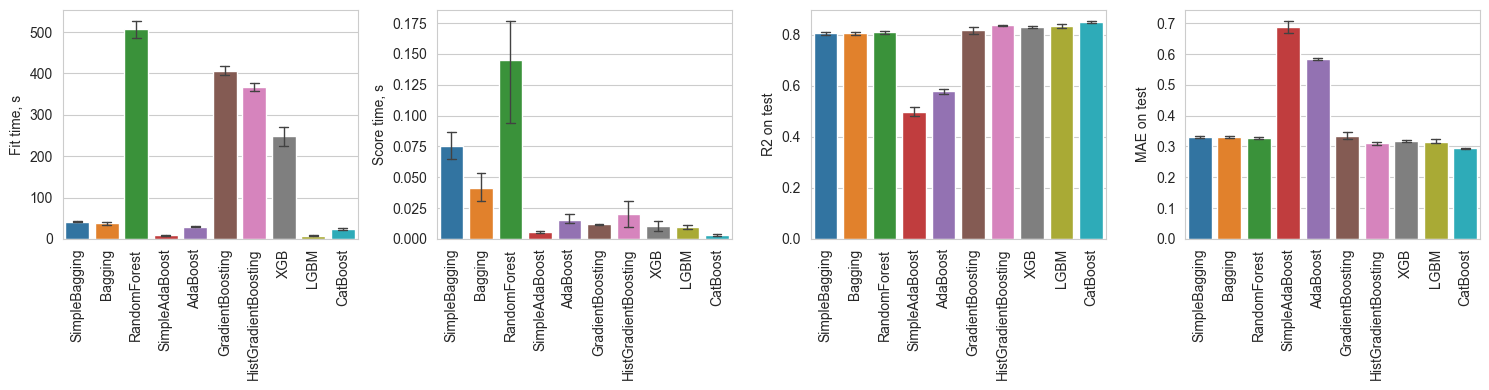

In [105]:
fig, axs = plt.subplots(ncols=4, figsize=(15, 4))

for y, ax in zip(["Fit time, s", "Score time, s", "R2 on test", "MAE on test"], axs.flatten()):
    sns.barplot(cv_results_amalgamated[["Regressor", y]], x="Regressor", y=y, errwidth=1, capsize=0.3, ax=ax)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel(None)

fig.tight_layout()

plt.show()

Наилучшие результаты по всем метрикам включая скорость показывает CatBoost — его средняя ошибка составляет менее $30000. Это около 15% от средней цены дома в датасете, то есть ошибка всё же может оказаться существенной.

Остальные алгоритмы, помимо основанных на AdaBoost, показывают себя не сильно хуже по качественным метрикам. Однако все они, будучи уже натренированными, работают дольше, хотя и на сотые доли секунды.